In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

try:
    from torch_lr_finder import LRFinder, AccumulationLRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder, AccumulationLRFinder

from apex import amp

..\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import random
import os
import numpy as np

SEED = 0

def reset_seed(seed):
    """
    ref: https://forums.fast.ai/t/accumulating-gradients/33219/28
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
data_folder = '../data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(data_folder, train=True, download=True, transform=transform)
# testset = datasets.MNIST(data_folder, train=False, download=True, transform=transform)

DESIRED_BATCH_SIZE = 256

## Warm up

In [5]:
reset_seed(SEED)
trainloader = DataLoader(trainset, batch_size=DESIRED_BATCH_SIZE, shuffle=True)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=10, step_mode='exp')
lr_finder.reset()

del optimizer, model, lr_finder


Learning rate search finished. See the graph with {finder_name}.plot()


## LRFinder

- Without `apex.amp`


Learning rate search finished. See the graph with {finder_name}.plot()


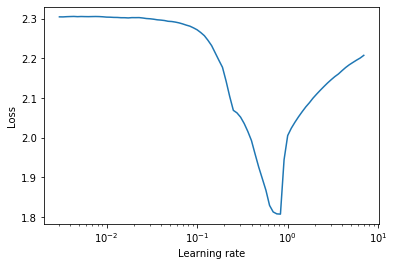

In [6]:
reset_seed(SEED)
trainloader = DataLoader(trainset, batch_size=DESIRED_BATCH_SIZE, shuffle=True)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

del optimizer, model, lr_finder

- With `apex.amp`, `opt_level = "O1"`

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0

Learning rate search finished. See the graph with {finder_name}.plot()


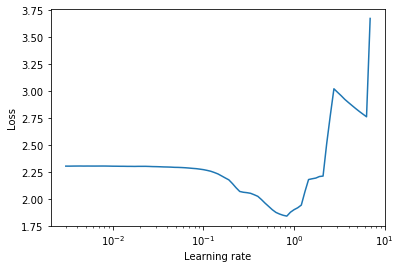

In [7]:
reset_seed(SEED)
trainloader = DataLoader(trainset, batch_size=DESIRED_BATCH_SIZE, shuffle=True)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

model, optimizer = amp.initialize(model, optimizer, opt_level='O1')

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

del optimizer, model, lr_finder

- With `apex.amp`, `opt_level = "O2"`

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0

Learning rate search finished. See the graph with {finder_name}.plot()


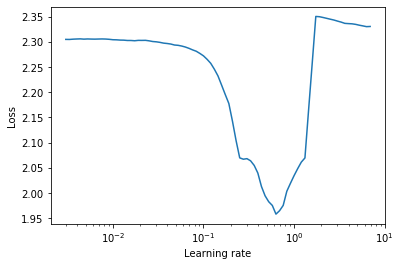

In [8]:
reset_seed(SEED)
trainloader = DataLoader(trainset, batch_size=DESIRED_BATCH_SIZE, shuffle=True)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

model, optimizer = amp.initialize(model, optimizer, opt_level='O2')

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

del optimizer, model, lr_finder